In [1]:
#import general libraries
import numpy as np
import pandas as pd
import pickle
from random import shuffle
from sklearn.preprocessing import LabelEncoder

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load library
from keras.preprocessing import image as image_utils
from imagenet_utils import decode_predictions
from imagenet_utils import preprocess_input
from vgg16 import VGG16
import numpy as np
import argparse
import cv2

Using TensorFlow backend.


In [3]:
#import libraries
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras import backend as K
from keras import applications
from keras import optimizers
from keras.models import Model

import h5py

In [5]:
#load movie id from 2005-2010
data = pd.read_csv("final_poster_label_2005_2010.csv")
#store movie ID
movieID = data["id"].values

In [32]:
###### read each image and resize 

# total number of posters
n = len(movieID)

# target image size
target_length = 224
target_width = 224

# np.array to store the whole matrix in the order of the movie id
img_matrix = np.zeros([n, target_length, target_width, 3])

for i in range(n):
    if i % 1000 == 0:    
        print (i)    
    
    movie_id = movieID[i]
    
    path = 'posters_2005_2010/' + str(movie_id) + '.jpg'
    
    #read image
    img = cv2.imread(path)
    
    # extract the length and width of the image
    img_length, img_width = np.asarray(img.shape[:2])

    
    ## put the image to the center of the array
    # calcuate location of the left edge
    left_loc = int(0.5*(target_width - img_width))
    # calcuate location of the top edge
    top_loc = int(0.5*(target_length - img_length))
    
    # store the image
    img_matrix[i, top_loc:(top_loc+img_length), 
               left_loc:(left_loc+img_width), :] = img
    
print ("Final data shape:")
img_matrix.shape

0
1000
2000
3000
4000
5000
Final data shape:


(5963, 224, 224, 3)

In [33]:
# reformat the data shape
if K.image_data_format() == 'channels_first':
    img_matrix = img_matrix.reshape(n, 3, target_length, target_width)
    input_shape = (3, target_length, target_width)
else:
    img_matrix = img_matrix.reshape(n, target_length, target_width, 3)
    input_shape = (target_length, target_width, 3)
    
# normalize image values to [0,1]
# interestingly the keras example code does not center the data
img_matrix = img_matrix.astype('float32')
img_matrix /= 255

print('data shape:', img_matrix.shape)

data shape: (5963, 224, 224, 3)


In [34]:
# y values: title position
y = data["title_location"].values

# count of different positions
for value in np.unique(y):
    print ("Value: {}, Count: {}.".format(value, len(y[y == value])))
    
# remove 'o' (other) from both x and y
index = (y == 't') + (y == 'b') + (y == 'm') #> 0 if any is true
y = y[index] >0
print (len(y))

img_matrix = img_matrix[index >0]
print (img_matrix.shape)

Value: nan, Count: 0.
Value: b, Count: 1797.
Value: m, Count: 1429.
Value: o, Count: 190.
Value: t, Count: 2545.
5771
(5771, 224, 224, 3)


In [35]:
### split train and test
# shuffle the samples
n = len(y)
index = range(n)
shuffle(index)

y = y[index]
img_matrix = img_matrix[index]

# one-hot-encode y
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)

# split train and test data
ratio = 0.7
split_num = int(n*ratio)

x_train = img_matrix[:split_num]
x_test = img_matrix[split_num:]

y_train = y_encoded[:split_num]
y_test = y_encoded[split_num:]

In [36]:
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 64
# this is fixed, we have 10 digits in our data set
num_classes = 3
# number of iterations over the complete training data
epochs = 16

# convert y values to the format for Keras
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [19]:
base_model.input ###?????

<tf.Tensor 'input_2:0' shape=(?, ?, ?, 3) dtype=float32>

In [16]:
# #weights_path
# weights_path = 'vgg16.weights.h5'

#load pretrained model
base_model =VGG16(weights='imagenet', include_top=False)

x = base_model.output 
x = GlobalAveragePooling2D()(x) # let's add a fully-connected layer 
x = Dense(1024, activation='relu')(x) # and a logistic layer -- let's say we have 200 classes 
predictions = Dense(200, activation='softmax')(x)  # this is the model we will train 
model = Model(inputs=base_model.input, outputs=predictions)


# # --- fully connected layer ---
# top_model.add(Dense(128, activation='relu'))
# top_model.add(Dense(256, activation='relu'))
# top_model.add(Dense(512, activation='relu'))
# top_model.add(Dropout(0.5))
# # --- classification ---
# top_model.add(Dense(num_classes, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
##### NO WEIGHTS YET 
# top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
# model.add(top_model)

# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False

In [17]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [21]:
#####TRY A DIFFERENT PRE-TRAINED MODEL

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(200, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# # train the model on the new data for a few epochs
# model.fit_generator(...)

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

0 input_3
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [37]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

ValueError: Error when checking model target: expected predictions to have shape (None, 1000) but got array with shape (4039, 3)

In [25]:
x_test.shape

(1732, 180, 124, 3)

In [26]:
y_test.shape

(1732, 3)

In [41]:
#####USE THE VERY ORIGINAL MODEL

#load pretrained model
base_model =VGG16(weights='imagenet', include_top=False)

x = base_model.output 
x = GlobalAveragePooling2D()(x) # let's add a fully-connected layer 
x = Dense(1024, activation='relu')(x) # and a logistic layer -- let's say we have 200 classes 
predictions = Dense(3, activation='softmax')(x)  # this is the model we will train 
model = Model(inputs=base_model.input, outputs=predictions)

# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False
    
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [ ]:
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')
model.fit(X, y, 
          batch_size=128, 
          nb_epoch=100, verbose=1, 
          callbacks=[earlyStopping], 
          validation_split=0.0, 
          validation_data=None, 
          shuffle=True, 
          show_accuracy=False, 
          class_weight=None, 
          sample_weight=None)

In [43]:
# fine-tune the model
nnet_mod = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 4039 samples, validate on 1732 samples
Epoch 1/16
4039/4039 [==============================] - 120s - loss: 0.2590 - acc: 0.9029 - val_loss: 0.0334 - val_acc: 1.0000

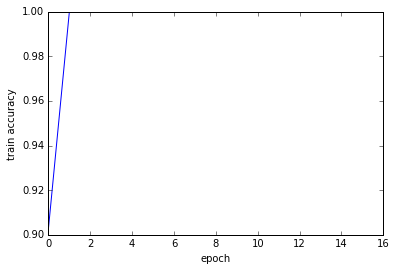

In [47]:
plt.plot(nnet_mod.history['acc'])
plt.xlabel("epoch")
plt.ylabel("train accuracy")

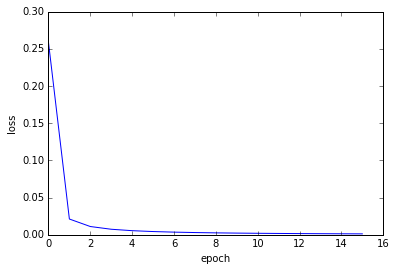

In [46]:
plt.plot(nnet_mod.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

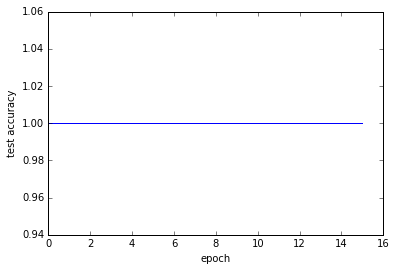

In [48]:
plt.plot(nnet_mod.history['val_acc'])
plt.xlabel("epoch")
plt.ylabel("test accuracy")

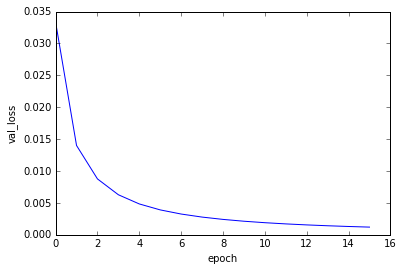

In [49]:
plt.plot(nnet_mod.history['val_loss'])
plt.xlabel("epoch")
plt.ylabel("val_loss")

In [22]:
base_model.input[:1]

<tf.Tensor 'strided_slice:0' shape=(?, ?, ?, 3) dtype=float32>